In [2]:
!pip install -q pandas scikit-learn streamlit pyngrok joblib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.6 MB/s eta 0:00:00


In [3]:
from google.colab import files
uploaded = files.upload()  # yahan 'SpotifyFeatures.csv' choose karke upload karo


Saving SpotifyFeatures.csv to SpotifyFeatures.csv


In [4]:
import pandas as pd

df = pd.read_csv("SpotifyFeatures.csv")  # filename exact same hona chahiye
print(df.shape)
print(df.columns.tolist()[:20])  # first 20 columns ka naam dekh lo
df.head()


(232725, 18)
['genre', 'artist_name', 'track_name', 'track_id', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [5]:
# apne dataset me ye columns hone chahiye:
# tempo, loudness, energy, valence, danceability, acousticness
# (plus 'track_name','artist_name','genre','popularity' agar recommendations chahiye)

need_cols = ['tempo','loudness','energy','valence','danceability','acousticness',
             'track_name','artist_name','genre','popularity']
have = [c for c in need_cols if c in df.columns]
df = df[have].dropna()

def mood(valence, energy):
    if valence >= 0.5 and energy >= 0.5:
        return "Happy"
    elif valence >= 0.5 and energy < 0.5:
        return "Calm"
    elif valence < 0.5 and energy >= 0.5:
        return "Energetic"
    else:
        return "Sad"

df['mood'] = [mood(v, e) for v, e in zip(df['valence'], df['energy'])]
df['mood'].value_counts()


,count
mood,
Happy,80303
Energetic,66667
Sad,64913
Calm,20841


In [6]:
from sklearn.model_selection import train_test_split

features = ['tempo','loudness','energy','valence','danceability','acousticness']
X = df[features]
y = df['mood']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((186179, 6), (46545, 6))

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced_subsample"
)
rf.fit(X_train, y_train)
print("✅ model trained")


✅ model trained


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
fi


              precision    recall  f1-score   support

        Calm       1.00      1.00      1.00      4168
   Energetic       1.00      1.00      1.00     13333
       Happy       1.00      1.00      1.00     16061
         Sad       1.00      1.00      1.00     12983

    accuracy                           1.00     46545
   macro avg       1.00      1.00      1.00     46545
weighted avg       1.00      1.00      1.00     46545

Confusion matrix:
 [[ 4168     0     0     0]
 [    0 13333     0     0]
 [    0     0 16061     0]
 [    0     0     0 12983]]


,0
valence,0.472463
energy,0.359983
loudness,0.080845
acousticness,0.046534
danceability,0.037994
tempo,0.002182


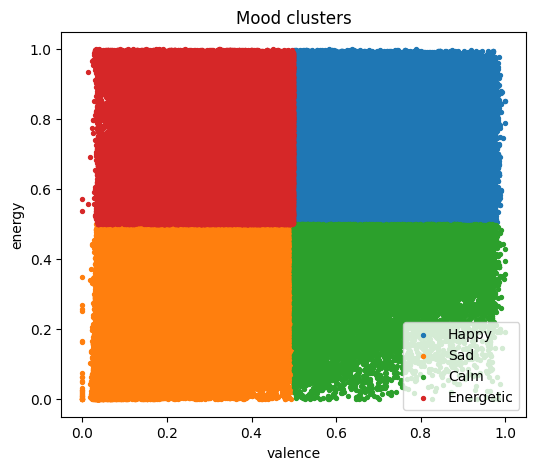

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
for m in df['mood'].unique():
    sub = df[df['mood']==m]
    plt.scatter(sub['valence'], sub['energy'], s=8, label=m)
plt.xlabel('valence'); plt.ylabel('energy'); plt.title('Mood clusters'); plt.legend()
plt.show()


In [10]:
import pandas as pd

def predict_mood(tempo, loudness, energy, valence, danceability, acousticness):
    X_in = pd.DataFrame([{
        'tempo': tempo, 'loudness': loudness, 'energy': energy, 'valence': valence,
        'danceability': danceability, 'acousticness': acousticness
    }])
    return rf.predict(X_in)[0]

predict_mood(120, -6.0, 0.7, 0.8, 0.6, 0.2)  # example


'Happy'

In [11]:
import joblib
joblib.dump(rf, "mood_classifier.joblib")
print("💾 saved -> mood_classifier.joblib")


💾 saved -> mood_classifier.joblib


In [12]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# load data & model
df = pd.read_csv("SpotifyFeatures.csv")
features = ['tempo','loudness','energy','valence','danceability','acousticness']
clf = joblib.load("mood_classifier.joblib")

def mood(valence, energy):
    if valence >= 0.5 and energy >= 0.5:
        return "Happy"
    elif valence >= 0.5 and energy < 0.5:
        return "Calm"
    elif valence < 0.5 and energy >= 0.5:
        return "Energetic"
    else:
        return "Sad"

# ensure mood column present for recommendations
if 'mood' not in df.columns:
    df['mood'] = [mood(v, e) for v, e in zip(df['valence'], df['energy'])]

st.set_page_config(page_title="Music Mood Classifier", page_icon="🎵", layout="wide")
st.title("🎵 Music Mood Classifier + Recommender")

tab1, tab2 = st.tabs(["Predict Mood (Features)", "Top Songs by Mood"])

with tab1:
    st.subheader("Enter audio features")
    tempo = st.slider("tempo", 40, 220, 120)
    loudness = st.slider("loudness (dB)", -40, 0, -6)
    energy = st.slider("energy", 0.0, 1.0, 0.7)
    valence = st.slider("valence", 0.0, 1.0, 0.6)
    danceability = st.slider("danceability", 0.0, 1.0, 0.6)
    acousticness = st.slider("acousticness", 0.0, 1.0, 0.2)

    X_in = pd.DataFrame([{
        'tempo': tempo,'loudness': loudness,'energy': energy,'valence': valence,
        'danceability': danceability,'acousticness': acousticness
    }])
    pred = clf.predict(X_in)[0]
    st.success(f"**Predicted Mood:** {pred}")

with tab2:
    st.subheader("Top 10 songs by mood")
    moods = sorted(df['mood'].unique())
    mood_choice = st.selectbox("Choose mood", moods)
    cols = [c for c in ['track_name','artist_name','genre','popularity'] if c in df.columns]
    top = df[df['mood']==mood_choice].sort_values(
        'popularity', ascending=False if 'popularity' in df.columns else True
    ).head(10)
    st.dataframe(top[cols])


Writing app.py


In [16]:
from pyngrok import ngrok

NGROK_TOKEN = "31GEdPFYVwcC8aAOnV33fpXtpVD_4ZnmAKiB7FUWzrFhdW9vy"  # <-- apna token yahan daalo
ngrok.set_auth_token(NGROK_TOKEN)

public_url = ngrok.connect(8501)
print("🌍 Public URL:", public_url)


🌍 Public URL: NgrokTunnel: "https://d00d31c87d95.ngrok-free.app" -> "http://localhost:8501"


In [15]:
!streamlit run app.py --server.port 8501 &>/dev/null &
